## Test different ideas for generating _future_ SSTs
### We'll look into Ice concentration later.

### Needed modules

In [ ]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

%matplotlib inline

### Local functions

In [ ]:
# file names: real data and daily climatology
def get_files_names(dates, data_path, file_pref, clim=False, file_suff=".nc"):
   files_to_read = []
   for idate in dates:

     if (clim==False): # real data
       ff = data_path + str(idate.year) + "/" +\
            file_pref + str(idate.year) + str(idate.month).zfill(2) + str(idate.day).zfill(2) +\
            file_suff
     else:
       ff = data_path + "/"+\
            file_pref + "0001" + str(idate.month).zfill(2) + str(idate.day).zfill(2) +\
            file_suff

     #print(ff)
     files_to_read.append(ff)
   return files_to_read

# We need to mask out land
def apply_mask( input_field, mask, tol=0.1):
  output_field = np.copy( input_field)
  output_field [mask<tol] = np.nan
  return output_field

# mask land
def mask_array(ds, iTime, mask=my_mask, vName='SST'):
    arr = ds[vName].isel(time=iTime).values
    masked_arr=apply_mask(arr, mask)
    return masked_arr

# to write forecast stats
def write_stats(vName, var):
    f1 = vName + "_{}_{}.csv".format(exp_dates[0].strftime('%Y%m%d'), exp_dates[-1].strftime('%Y%m%d'))
    print("Writing out: ", f1)
    np.savetxt(f1, (var), delimiter=",", fmt='%1.4f')
    print("Done!")

# User set arguments

| variable | What is it? |
| :--      | --:         |
| fcst_nDays | Typical number of days of a single forecast |
| nfcst | How many forecasts should we try |
| start_date | Start date of ALL the forecasts |
| end_date   | End date of ALL the forecasts |
| data_path_real | Path to `netcdf` version of **daily** GMAO OPS SST and sea ice boundary conditions (BCs)|
| data_path_clim | Path to daily climatology of GMAO OPS BCs, based on 2007- 2023 |


## Methods:
1. **Persist**: Use SST of first day ($x0$) of forecast for all `fcst_nDays`
    $$x(d) = x(0)\,\, \forall d > 0.$$
2. **Persist initial anomaly**: Persist anomaly (with respect to daily clim: $\bar{x}$) of $x(0)$ for for all `fcst_nDays`
    $$\delta x(d) = x(d) - \bar{x}(d) \, \forall d, $$
    $$x(d) = \bar{x}(d) + \delta x(0)\,\, \forall d > 0.$$
3. **Test3**: See below!
    $$x(d) = \bar{x}(d) - \delta x(0).$$
4. **Test4**:
    $$x(d) = x(0) + \delta x(0).$$
5. **Test5**:
    $$x(d) = x(0) + \delta x(-d).$$
    
### Remarks:
- We will _march_ in time: `start_date` -> `end_date` in increments of `fcst_nDays`.
- Above implies `end_date` **must** _fit_ with `nfcst`.
- Check with Kristian Mogensen to be sure above `Persist initial anomaly` was done this way at ECMWF **before** coupled forecasts in IFS.

In [ ]:
fcst_nDays, nfcst = [10, 30]

start_date, end_date = ['2017-06-01', '2017-07-01'] # end_date must fit above.

data_path_real = "/discover/nobackup/projects/gmao/advda/sakella/future_sst_fraci/GMAO_OPS_bin_data/data/"
data_path_clim = "/discover/nobackup/projects/gmao/advda/sakella/future_sst_fraci/data/ncFiles/"

file_pref_real, file_suff = ["sst_ice_", ".nc"]
file_pref_clim, file_suff = ["daily_clim_mean_sst_fraci_", ".nc"]

#method = "persist" 
#method = "persist_init_anom"
#method = "test3"
method = "test4"

## Dates of all forecasts

In [ ]:
# One forecast per day-- since this is daily SST.
exp_dates  = pd.date_range(start_date, end_date, freq='D')

## To apply land-sea mask

In [ ]:
land_sea_mask = xr.open_dataset("/discover/nobackup/projects/gmao/advda/sakella/future_sst_fraci/gen_daily_clim_data/data/geos_fp_bcs_land_sea_mask.nc")
my_mask = land_sea_mask.land_mask.values

## Initialize arrays that hold mean and std dev

In [ ]:
# With respect to real data -- remember, we _test_ in **hindcast** mode, so we know the _truth_.
mean_error = np.zeros((fcst_nDays, nfcst), dtype=np.float64)
sdev_error = np.zeros_like( mean_error)

spatial_error = np.full((fcst_nDays, my_mask.shape[0], my_mask.shape[1]), np.nan)#-999*np.ones((fcst_nDays, my_mask.shape[0], my_mask.shape[1]), dtype=np.float32)

# With respect to daily climatology
mean_error_clim = np.zeros((fcst_nDays, nfcst), dtype=np.float64)
sdev_error_clim = np.zeros_like( mean_error_clim)

## Compute

In [ ]:
for ifcst in range(1, nfcst+1): # each forecast

  fcst_start_date = exp_dates[0] + pd.DateOffset(days=ifcst-1)
  fcst_dates = pd.date_range(start=fcst_start_date, periods=fcst_nDays)
  print("Forecast [{}] Dates: {}".format(ifcst,fcst_dates))

  files_names_real_data = get_files_names(fcst_dates, data_path_real, file_pref_real)
  clim_files_names      = get_files_names(fcst_dates, data_path_clim, file_pref_clim, clim=True)

  ds_real = xr.open_mfdataset(files_names_real_data)
  ds_clim = xr.open_mfdataset(clim_files_names, concat_dim='time', combine='nested', use_cftime=True)

  for id in range(0, fcst_nDays): # over each day of forecast
    real_sst = mask_array(ds_real, id); clim_sst = mask_array(ds_clim, id)

    # save initial SST
    if (id==0):
      sst0  = real_sst; anam0 = sst0 - clim_sst

    predicted_sst = np.zeros_like(sst0) # init to be safe!    

    if method == "persist":
        predicted_sst = sst0 # persistence throughout the forecast
    elif method == "persist_init_anom":
        if (id==0):
            predicted_sst = sst0 # forecast start day
        else:
            predicted_sst = clim_sst + anam0
    elif method == "test3":
        if (id==0):
            predicted_sst = sst0 # forecast start day
        else:
            predicted_sst = clim_sst - anam0
    elif method == "test4":
        if (id==0):
            predicted_sst = sst0 # forecast start day
        else:
            predicted_sst = sst0 + anam0         
    else:
        print("Uknown method: {} for creating future SSTs.".format(method))
    
    if (ifcst ==1): # first forecast
      spatial_error[id,:,:] = predicted_sst - real_sst
    else:
      spatial_error[id,:,:] = spatial_error[id,:,:] + (predicted_sst - real_sst)

    dsst_error = (real_sst - predicted_sst).flatten()
    dsst_clim  = (real_sst - clim_sst).flatten() # use climatology as _best_ guess

    # unweighted global mean and std. dev. <-- add weighting
    mean_error[id,ifcst-1], sdev_error[id, ifcst-1] =\
    [np.nanmean(dsst_error, dtype=np.float64), np.nanstd(dsst_error, dtype=np.float64)]

    mean_error_clim[id,ifcst-1], sdev_error_clim[id, ifcst-1] =\
    [np.nanmean(dsst_clim, dtype=np.float64), np.nanstd(dsst_clim, dtype=np.float64)]
#    
for id in range(0, fcst_nDays):
    spatial_error[id,:,:] = spatial_error[id,:,:]/nfcst  

### Plot

In [ ]:
plt.figure( figsize=(12, 4))
plt.subplot(121)
for id in range(0, nfcst):
  plt.plot(range(0, fcst_nDays), mean_error[:,id],      ls='-', c='b')
  plt.plot(range(0, fcst_nDays), mean_error_clim[:,id], ls='-', c='k')
plt.title('Global mean error ($^\circ$K)')
plt.xlabel('Forecast days')
plt.grid(True)
plt.ylim(-0.2, 0.2)
#
plt.subplot(122)
for id in range(0, nfcst):
  plt.plot(range(0, fcst_nDays), sdev_error[:,id],      ls='-', c='b')
  plt.plot(range(0, fcst_nDays), sdev_error_clim[:,id], ls='-', c='k')
plt.title('SDEV of global mean error ($^\circ$K)')
plt.xlabel('Forecast days')
plt.grid(True)
plt.ylim(0., 1.0)

In [ ]:
plt.figure( figsize=(16, 10))

for id in range(0, fcst_nDays):
    plt.subplot(4, 3, id+1)
    plt.pcolormesh(land_sea_mask.lon.values, land_sea_mask.lat.values,\
                   spatial_error[id,:,:], vmin=-1, vmax=1, cmap=plt.cm.bwr)
    plt.colorbar()
    plt.title('day: {}'.format(id))

## Save processed data (later)

In [209]:
write_stats('mean_error_' + method, mean_error)
write_stats('sdev_error_', sdev_error)

write_stats('mean_error_clim_', mean_error_clim)
write_stats('sdev_error_clim_', sdev_error_clim)

Writing out:  mean_error_test4_20170601_20170701.csv
Done!
Writing out:  sdev_error__20170601_20170701.csv
Done!
Writing out:  mean_error_clim__20170601_20170701.csv
Done!
Writing out:  sdev_error_clim__20170601_20170701.csv
Done!


In [210]:
da = xr.DataArray(data=spatial_error, 
coords={'time': np.arange(0, fcst_nDays), 'lat': land_sea_mask.lat,'lon': land_sea_mask.lon}, 
dims=["time", "lat", "lon"],
attrs=dict(description="forecast error in SST, see https://github.com/sanAkel/future_sst_fraci/blob/main/to_gen_new_files/SST_ideas.ipynb"))

ds_sst_err = da.to_dataset(name='sst_fcst_error')

#ds_sst_err.sst_fcst_error.plot(x="lon", y="lat", col="time", col_wrap=3)
ds_sst_err.to_netcdf("sst_fcst_err_{}_{}_{}.nc".format(method, exp_dates[0].strftime('%Y%m%d'), exp_dates[-1].strftime('%Y%m%d')))

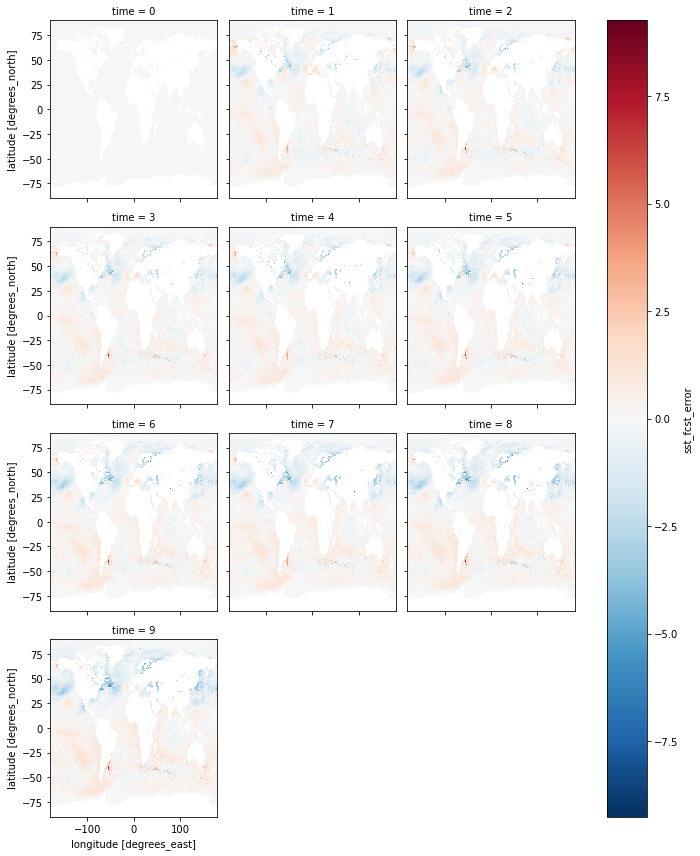